<a href="https://colab.research.google.com/github/SurajWijewickrama/Tree-People/blob/main/Animus_AssetGenerationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/justinpinkney/stable-diffusion.git
%cd stable-diffusion
!pip install --upgrade pip
!pip install -r requirements.txt

!pip install --upgrade keras # on lambda stack we need to upgrade keras
!pip uninstall -y torchtext # on colab we need to remove torchtext

Cloning into 'stable-diffusion'...
remote: Enumerating objects: 1747, done.
remote: Total 1747 (delta 0), reused 0 (delta 0), pack-reused 1747
Receiving objects: 100% (1747/1747), 73.93 MiB | 33.47 MiB/s, done.
Resolving deltas: 100% (1079/1079), done.
/content/stable-diffusion
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers (from -r requirements.txt (line 23))
  Cloning https://github.com/CompVis/taming-transformers.git (to revision master) to ./src/taming-trans

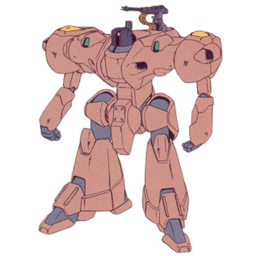

In [18]:
# Check the dataset
from datasets import load_dataset
ds = load_dataset("Gazoche/gundam-captioned", split="train")
sample = ds[0]
display(sample["image"].resize((256, 256)))

In [19]:

!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [20]:
from huggingface_hub import hf_hub_download
ckpt_path = hf_hub_download(repo_id="CompVis/stable-diffusion-v-1-4-original", filename="sd-v1-4-full-ema.ckpt", use_auth_token=True)

In [21]:
# 2xA6000:
BATCH_SIZE = 4
N_GPUS = 2
ACCUMULATE_BATCHES = 1

gpu_list = ",".join((str(x) for x in range(N_GPUS))) + ","
print(f"Using GPUs: {gpu_list}")

Using GPUs: 0,1,


In [22]:
!(python main.py \
    -t \
    --base configs/stable-diffusion/pokemon.yaml \
    --gpus "$gpu_list" \
    --scale_lr False \
    --num_nodes 1 \
    --check_val_every_n_epoch 10 \
    --finetune_from "$ckpt_path" \
    data.params.batch_size="$BATCH_SIZE" \
    lightning.trainer.accumulate_grad_batches="$ACCUMULATE_BATCHES" \
    data.params.validation.params.n_gpus="$NUM_GPUS" \
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
Moving 0 files to the new cache system
0it [00:00, ?it/s]
usage: main.py
       [-h]
       [--finetune_from [FINETUNE_FROM]]
       [-n [NAME]]
       [-r [RESUME]]
       [-b [base_config.yaml [base_config.yaml ...]]]
       [-t [TRAIN]]
       [--no-test [NO_TEST]]
       [-p PROJECT]
       [-d [DEBUG]]
       [-s SEED]
       [-f POSTFIX]
       [-l LOGDIR]
       [--scale_lr [SCALE_LR]]
       [--logger [LOGGER]]
       [--checkpoint_callback [CHECKPOINT_CALLBACK]]
       [--default_root_dir DEFAULT_ROOT_DIR]
       [--gradient_clip_val GRADIENT_CLIP_VAL]
       [--gradient_clip_algorithm GRADIENT_CLIP_ALGORITHM]
       [--process_position PROCESS_POSITION]
       [--num_nodes NUM_NODES]
       [--num_processes NUM_PROCESSES]
       [--devices DEVICES]

In [23]:
# Run the model
!(python scripts/txt2img.py \
    --prompt 'robotic cat with wings' \
    --outdir 'outputs/generated_pokemon' \
    --H 512 --W 512 \
    --n_samples 4 \
    --config 'configs/stable-diffusion/pokemon.yaml' \
    --ckpt 'path/to/your/checkpoint')

Global seed set to 42
Loading model from path/to/your/checkpoint
Traceback (most recent call last):
  File "scripts/txt2img.py", line 285, in <module>
    main()
  File "scripts/txt2img.py", line 194, in main
    model = load_model_from_config(config, f"{opt.ckpt}")
  File "scripts/txt2img.py", line 27, in load_model_from_config
    pl_sd = torch.load(ckpt, map_location="cpu")
  File "/usr/local/lib/python3.8/dist-packages/torch/serialization.py", line 699, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.8/dist-packages/torch/serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.8/dist-packages/torch/serialization.py", line 211, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: 'path/to/your/checkpoint'
